# Figure6 Peaks number, average length and signal to noise ratio

Peak calling tuning improvement from defaults to tuned ZINBRA.

In [13]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from collections import OrderedDict, Counter

AGE_PALETTE = {'Old': '#E41A1C', 'Young': '#377EB8'}

TOOLS_PALETTE = {'MACS2': "#EDEDED", 'SICER': "#EDEDED", 'ZINBRA': '#FBE5D6'}


df = pd.read_csv('/mnt/stripe/bio/experiments/configs/Y20O20/benchmark/Y20O20_peaks_summary_uli.tsv', 
                 sep='\t', comment='#')
df = df.loc[df['status'] != 'failed']

# Graphics of peaks number across different marks and tools

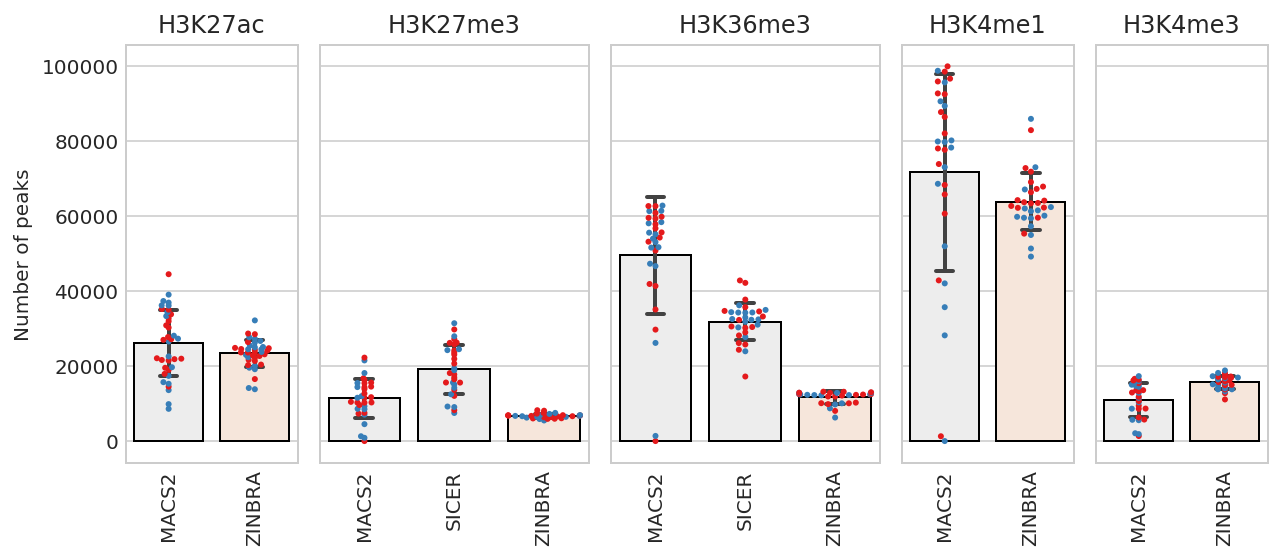

In [14]:
toshow = OrderedDict([
    ("H3K27ac", [("MACS2", "default"), ("ZINBRA", "tuned")]),
    ("H3K27me3", [("MACS2", "default"), ("SICER", "default"), ("ZINBRA", "tuned")]),
    ("H3K36me3", [("MACS2", "default"), ("SICER", "default"), ("ZINBRA", "tuned")]),
    ("H3K4me1", [("MACS2", "default"), ("ZINBRA", "tuned")]),
    ("H3K4me3", [("MACS2", "default"), ("ZINBRA", "tuned")])
])

# Filter out dataframe to given combination of target, tool and procedure.
dfs = []
for m, tps in toshow.items():
    for (tool, procedure) in tps:
        dfmtp = df.loc[np.logical_and(df['tool'] == tool, 
                          np.logical_and(df['modification'] == m, 
                                         df['procedure'] == procedure))]
        dfs.append(dfmtp)
dft = pd.concat(dfs, axis=0)


def plot_data(dft, value, description):
    dft['mp'] = dft['modification'] + " " + dft['tool'] + " " + dft['procedure']
    dft["age"] = "Young"
    dft.loc[dft.donor.str.startswith("OD"), "age"] = "Old"

    
    ms = ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']
    axs = {}
    mpl = len(set(dft['mp']))
    fig = plt.figure(figsize=(int(len(set(dft['mp'])) * .75), 4))
    offset = 0
    for m in ms:
        data = dft.loc[dft['modification'] == m]
        xlabels = []
        for t in data['tool']:
            if t not in xlabels:
                xlabels.append(t)
        w = len(set(data['mp']))
        ax = plt.subplot2grid((1, mpl), (0, offset), colspan=w)

        sns.barplot(data=data, 
                 x="tool", y=value,
                 ci="sd", capsize=.2, errwidth=2,
                 palette=TOOLS_PALETTE, 
                 edgecolor="black",
                 ax = ax)

        sns.swarmplot(data=data,
              x="tool", y=value,
              size=3, #5
              hue = "age",
              palette=AGE_PALETTE,
              ax = ax)
        ax.legend().set_visible(False)
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(description)
        
        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        plt.xticks(range(0, len(xlabels)), xlabels, rotation=90)
            
    ymin = np.min([v[0] for v in axs.values()])
    ymax = np.max([v[1] for v in axs.values()])
 
    for ax in axs.keys():
        ax.set_ylim(bottom = ymin, top = ymax)
    plt.tight_layout()
    
    
# Plot peaks number
with PdfPages('/mnt/stripe/figures/peaks_number.pdf') as pdf:
    plot_data(dft, 'peaks', 'Number of peaks')
    pdf.savefig()

# Average peak length by modification and tool

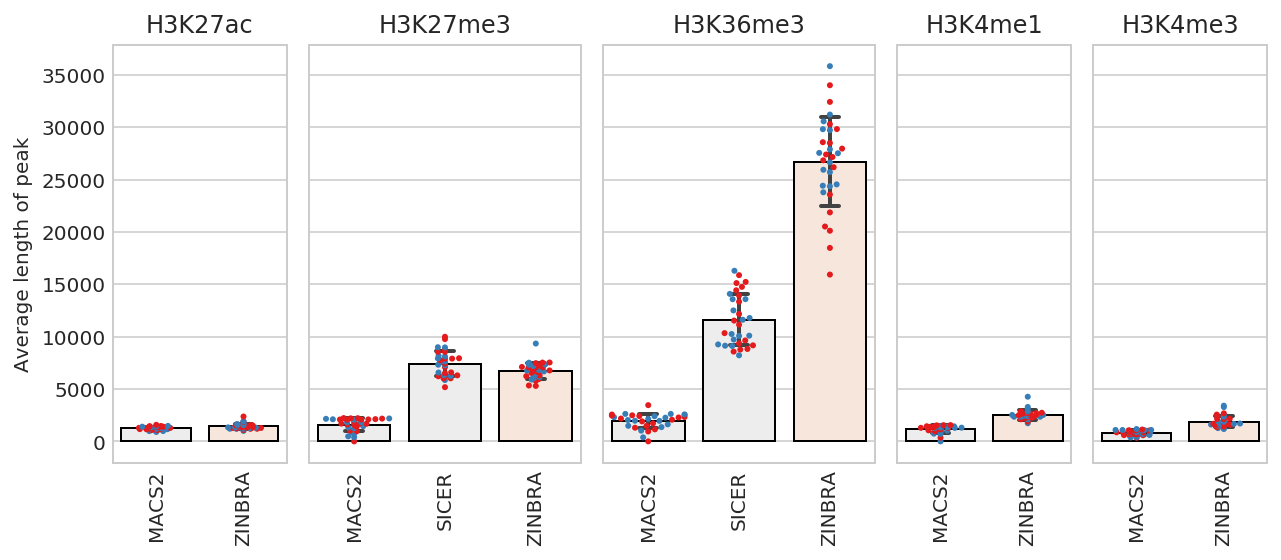

In [15]:
dft['len_avg'] = dft['length'] / dft['peaks']
dft.loc[~np.isfinite(dft["len_avg"]), "len_avg"] = 0.0

with PdfPages('/mnt/stripe/figures/peaks_length.pdf') as pdf:
    plot_data(dft, 'len_avg', 'Average length of peak')
    pdf.savefig()

In [16]:
# OD14 is the highest in terms of avg peaks length, 
# it has small number of peaks with big summary length and one of the highest FRIP value
display(dft.loc[dft['mp']=='H3K36me3 ZINBRA tuned'])

,donor,modification,tool,peaks,length,frip,procedure,params,file,status,mp,age,len_avg
688,YD14,H3K36me3,ZINBRA,12874,342933400,0.617493,tuned,200_1.0E-6_40,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Young,26637.672829
690,OD4,H3K36me3,ZINBRA,12842,344618000,0.546872,tuned,200_1.0E-8_40,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,26835.228158
691,OD5,H3K36me3,ZINBRA,10077,275998800,0.461660,tuned,200_1.0E-8_60,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,27388.984817
693,OD7,H3K36me3,ZINBRA,13168,209708800,0.348261,tuned,200_1.0E-8_40,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,15925.637910
694,OD8,H3K36me3,ZINBRA,12322,351981800,0.520284,tuned,200_1.0E-6_40,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,28565.314072
695,OD9,H3K36me3,ZINBRA,8049,165109600,0.216462,tuned,200_1.0E-8_80,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,20513.057523
696,OD10,H3K36me3,ZINBRA,10101,301177400,0.492646,tuned,200_1.0E-8_60,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,29816.592417
697,OD11,H3K36me3,ZINBRA,12409,292468400,0.521488,tuned,200_1.0E-6_40,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,23569.054718
698,OD12,H3K36me3,ZINBRA,12514,405613400,0.380248,tuned,200_1.0E-6_60,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,32412.769698
699,OD13,H3K36me3,ZINBRA,10249,348489800,0.658540,tuned,200_1.0E-8_60,/mnt/stripe/bio/experiments/configs/Y20O20/ben...,ok,H3K36me3 ZINBRA tuned,Old,34002.322178


# Signal to noise ratio

Computed by `ChipSeqSignalToNoise` experiment.

Input file: `/mnt/stripe/bio/experiments/signal_to_noise/signal_to_noise.tsv`

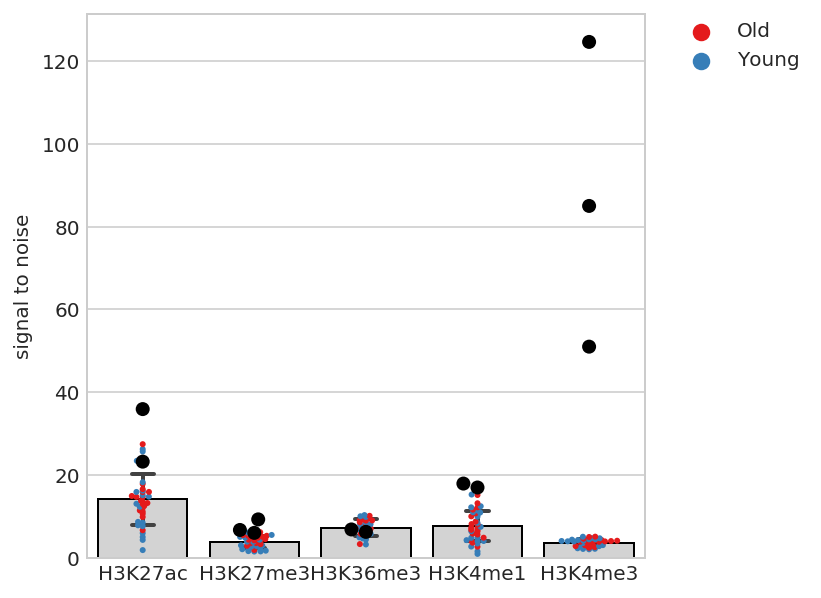

In [17]:
sn_df = pd.read_csv('/mnt/stripe/bio/experiments/signal_to_noise/signal_to_noise_Y20O20.tsv', 
                    sep='\t', names=['modification', 'cell', 'donor', 'sn', 'file'])

sn_df["age"] = "Young"
sn_df.loc[sn_df.donor.str.startswith("OD"), "age"] = "Old"

sn_df_encode = pd.read_csv('/mnt/stripe/bio/experiments/signal_to_noise/signal_to_noise_cd14encode.tsv', 
                            sep='\t', names=['modification', 'cell', 'donor', 'sn', 'file'])


fig = plt.figure(figsize=(5, 5))
sns.set_style("whitegrid")

ax = sns.barplot(data=sn_df, 
         x="modification", y='sn',
         ci="sd", capsize=.2, errwidth=2,
         color="lightgray",
         edgecolor="black")

ax = sns.swarmplot(data=sn_df, 
      x="modification", y='sn',
      size=3, #5
      hue = "age",
      palette=AGE_PALETTE)

ax = sns.swarmplot(data=sn_df_encode, 
      x="modification", y='sn',
      size=7, #5
      color='black')

plt.xlabel('')
plt.ylabel('signal to noise')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.show()